# Mapa pražských kaváren

Udělejme si malý projekt na zmapování kaváren v Praze, použijeme ho zároveň k tomu, abychom si ukázali, jak pracovat s geografickými daty a jak je zakreslit do mapy. 

## Získání dat

Získání poloh všech kaváren v Praze je relativně zajímavý úkol sám o sobě. Dá se na něm ilustrovat, jak získat data z internetovývh stránek. V našem případě získáme adresy všech kaváren v Praze ze stránek firmy.cz. Když se na tyto stránky podíváte, uvidíte, že adresy jsou na nich obaleny v tagu `<span class='address'>`, ten v sobě ještě obsahuje dva další `span` tagy s `class=addrpart`.

Bohužel, stránka je generovaná pomocí JavaScriptu, takže není možné jednoduše přistoupit na adresu, stáhnout stránku a vyhledat tagy. Potřebuje použít něco, co JavaScript podporuje. K tomu nám může posloužit například projekt selenium, který umožňuje programově ovládat (téměř) libovolný prohlížeč. My ho použijeme jen k otevření stránky a uložení jejího zdrojového kódu, ze kterého si vytáhneme požadované informace.

Více informací o projektu selenium a jeho použití viz http://docs.seleniumhq.org/.

Získaná data jsou zároveň uložena v souboru `kavarny.json` abyste je nemuseli stahovat znovu.

In [ ]:
import lxml.html
from urllib.parse import quote
from selenium import webdriver
import time

def get_addr_from_page(num):
    driver = webdriver.Chrome('chromeDriver/chromedriver.exe')  # Cesta k driveru pro Chrome
    
    driver.get('http://www.firmy.cz/Restauracni-a-pohostinske-sluzby/Kavarny/kraj-praha?page=' + str(num));
    time.sleep(5) # 5 vterin na nacteni stranky staci
    src = driver.page_source
    driver.quit()
    
    doc = lxml.html.document_fromstring(src) # pouzijeme XML parser z ziskani potrebnych udaju
    el = doc.xpath("//span[@class='address']") # tenhle XPath by to mel udelat
    return [[x.text for x in y] for y in el] # vytahneme text z tagu vnorenych do <span class=address>

Když umíme získat adresy z jedné stránky není už níjak těžké získat je ze všech stránek. Stačí zjistit, že výše napsaná funkce vrátí na neexistující stránce prázdný seznam. Následující jednoduchý cyklus získá postupně data ze všech stránek. Poslední řádka potom pospojuje jednotlivé části adres do celých adres. (Občas se ve výstupu z výše uvedené funkce objeví None místo textu - když je daný span prázdný, proto je ta řádka tak složitá).

In [ ]:
addr = []
i = 1

new_addr = get_addr_from_page(i)
while new_addr:
    addr.extend(new_addr)
    i+=1
    new_addr = get_addr_from_page(i)
    
address = list({' '.join(map(lambda x : '' if x is None else x, y)) for y in addr})

S adresami se obecně dost špatně pracuje, nicméně, Google má API, které převede adresu na zeměpisné souřadnice. S těmi se pracuje mnohem lépe. Funkce, která převede jednu adresu na souřadnice je uvedena níže. Vrací dictionary, ve kterém jsou pouze dvě položky s klíči 'lng' a 'lat'. 

Samotný cyklus, který potom převádí všechny adresy na souřadnice je opět velmi jednoduchý. Překvapivě jsem ale zjistil, že Google API realtivně často vrátí místo výsledku chybu, bohužel se mi nepodařilo zjisit proč (na stejný dotaz ji občas vrátilo a občas zase ne).

In [ ]:
import json

def address_to_location(address):
    API_URL = 'http://maps.googleapis.com/maps/api/geocode/json?address='
    reply = urlopen(API_URL + quote(address)).read().decode('utf-8')
    loc = json.loads(reply)['results'][0]['geometry']['location']
    return loc

locations = []

for addr in address:
    print('Getting location for ', addr)
    loc = address_to_location(addr)
    locations.append(loc)
    print('\t', loc)
    time.sleep(1) #Google Maps API ma limit na 10 dotazu za vterinu (a 2500 za den)

Jak už jsem říkal na začátku, data jsem uložil do souboru `kavarny.json`, teď si je tedy načteme a použijeme. Jsou uložena jako seznam dictionary s třemi záznamy: `addr`, `lat` a `lng`.

Data nakonec ještě převedeme do `pandas.DataFrame`, se kterých se o něco lépe pracuje (ale tady je to skoro jedno).

In [1]:
import json

data = json.load(open('kavarny.json'))

address = [d['addr'] for d in data]
lat = [d['lat'] for d in data]
lng = [d['lng'] for d in data]

import pandas as pd

kavarny = pd.DataFrame()

kavarny['address'] = address
kavarny['lat'] = lat
kavarny['lng'] = lng

kavarny[:10]

,address,lat,lng
0,"Míšeňská 70/4, Praha, Malá Strana",50.087814,14.408278
1,"Slavíkova 1606/21, Praha, Vinohrady",50.080365,14.446452
2,"Vodičkova 791/41, Praha, Nové Město",50.082178,14.425751
3,"U Zvonařky 1423/7, Praha, Vinohrady",50.070345,14.434022
4,"Táborská 117/21, Praha, Nusle",50.061204,14.436530
5,"U Santošky 944/16, Praha",50.067711,14.399622
6,"Thámova 221/7, Praha",50.091440,14.452656
7,"Konviktská 291/24, Praha, Staré Město",50.083555,14.417157
8,"Opatovická 154/26, Praha, Nové Město",50.080255,14.418631
9,"Františka Křížka 460/15, Praha, Holešovice",50.100055,14.430177


# Vizualizace dat

Zeměpisné souřadnice už jsou čísla, se kterými se dá pracovat, můžeme si například zkusit namalovat scatterplot kaváren. Sám o sobě (bez mapy) nám toho ale asi moc neřekne.

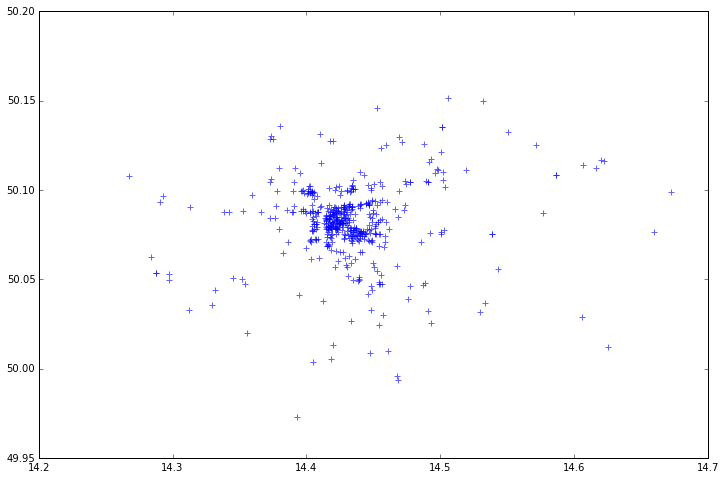

In [6]:
# nasledujici magic umoznuje zobrazovat obrazky primo v notebooku
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8)) # nastavime rozumnou velikost obrazku
plt.scatter(kavarny['lng'], kavarny['lat'], alpha=0.6, marker='+', s=40) # nastaveni alespon male pruhledosti 
                                                       # trochu zprehlednuje obrazek, kde se prekryva hodne hodnot
plt.show() # je tady zbytecne, ale aspon nema zadny vystup, jako predchazejici prikaz

Mnohem lepší je samozřejmě zakreslit souřadnice přímo do mapy, k tomu může dobře posloužit knihovna `cartopy`. Příklad jejího použití vidíme v následující ukázce, kde zobrazíme souřadnice kaváren na mapě z OpenStreetMaps. Knihovna `cartopy` umí ale použít i jiné zdroje a dokonce má některé mapy (obrysy států a kontinentů) přímo vestavěné. Pokud vás kreslení do map zajímá, podívejte se na dokumentaci na http://scitools.org.uk/cartopy/docs/latest/index.html.

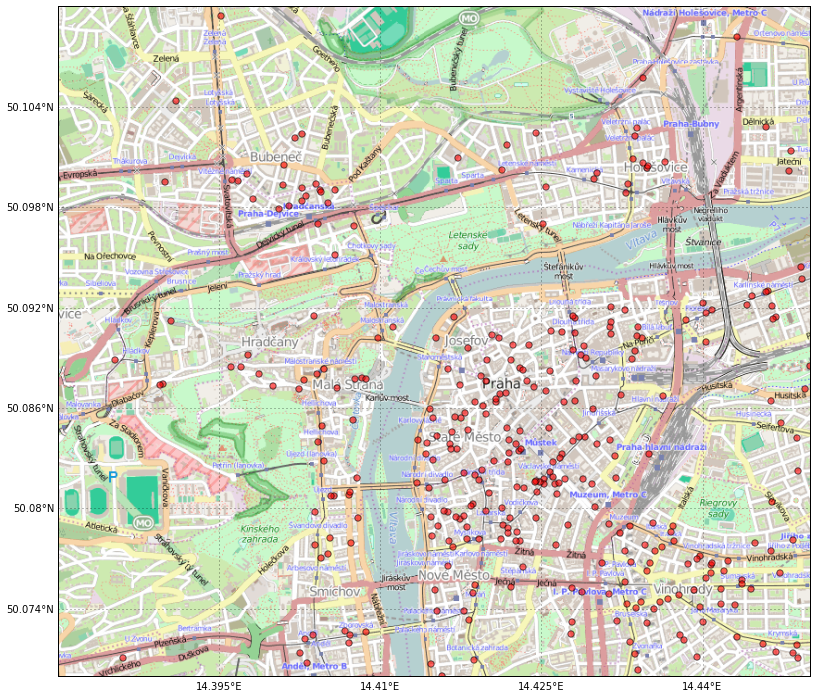

In [3]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimg
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

MIN_LNG = 14.38
MAX_LNG = 14.45
MIN_LAT = 50.07
MAX_LAT = 50.11

def make_map(figsize=(16, 12), projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

extent = [MIN_LNG, MAX_LNG, MIN_LAT, MAX_LAT]

request = cimg.OSM()
fig, ax = make_map(figsize=(16,12), projection=request.crs)
ax.set_extent(extent)

ax.add_image(request, 14) # 14 je nastaveni zoom-level pro OSM mapy, cim vyssi cislo, tim vice detailu a tim dele trva stahovani
ax.scatter(kavarny['lng'], kavarny['lat'], transform=ccrs.PlateCarree(), alpha=0.6, s=40, c='red')
plt.show()

Kromě zakreslení kaváren do mapy, by nás mohlo zajímat, kde je v Praze největší hustota kaváren. K tomu se dá přistoupit několika způsoby, tady si ukážeme postup, který předpokládá, že polohy kaváren jsou generované ze směsi Gaussovských rozdělení a potom zakreslí hustotu této směsi do mapy. Nevýhoda tohoto způsobu zobrazení je, že je třeba parametry poladit tak, aby obrázek vypadal hezky a navíc trénování modelů není deterministické a obrázky se po přetrénování mohou lišit.

Další možnost by mohla být spočítat počet kaváren v okolí každého bodu na mapě a obarvit mapu podle toho, nebo spočítat průměrnou vzdálenost k několika nejbližším kavárnám.

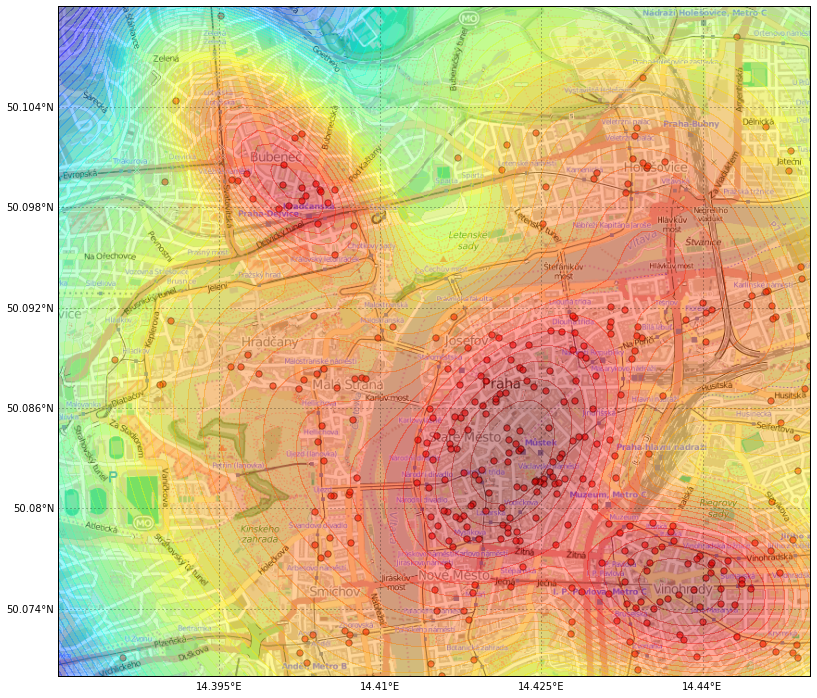

In [4]:
from sklearn import mixture
import numpy as np

filt = kavarny[kavarny.lng.between(MIN_LNG,MAX_LNG)&kavarny.lat.between(MIN_LAT, MAX_LAT)] # vyfiltrujeme jen kavarny, ktere
                                                                                           # jsou videt na mape

X_train = np.array(list(zip(filt['lng'], filt['lat']))) # vytovorime trenovaci mnozinu ze souradnic kavaren

# natrenujeme GMM (Gaussian Mixture Model) models peti komponentami
clf = mixture.GMM(n_components=6, covariance_type='full', min_covar=0.0000001)
clf.fit(X_train)

# a zobrazime vystup modelu na mape
x = np.linspace(MIN_LNG, MAX_LNG)
y = np.linspace(MIN_LAT, MAX_LAT)
X, Y = np.meshgrid(x, y) # vytvorime si usporadane dvojice x a y souradnic
XX = np.array([X.ravel(), Y.ravel()]).T 
Z = clf.score_samples(XX)[0] # vyhodnotime model v techto bodech
Z = Z.reshape(X.shape)

request = cimg.OSM() # zase pouzijeme OSM mapy
fig, ax = make_map(figsize=(16,12), projection=request.crs)
ax.set_extent(extent)

ax.add_image(request, 14)
ax.scatter(kavarny['lng'], kavarny['lat'], transform=ccrs.PlateCarree(), alpha=0.6, s=40, c='red') # zakreslime kavarny
ax.contourf(X, Y, Z, transform=ccrs.PlateCarree(), levels=np.linspace(np.min(Z), np.max(Z)), alpha=0.4) # a jejich hustotu

plt.show()